**Clone dataset repo**

In [1]:
!git clone https://github.com/dessertlab/Targeted-Data-Poisoning-Attacks.git
!git clone https://github.com/s2e-lab/SecurityEval

Cloning into 'Targeted-Data-Poisoning-Attacks'...
remote: Enumerating objects: 305, done.
remote: Counting objects: 100% (305/305), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 305 (delta 173), reused 277 (delta 153), pack-reused 0 (from 0)
Receiving objects: 100% (305/305), 3.47 MiB | 17.41 MiB/s, done.
Resolving deltas: 100% (173/173), done.
Cloning into 'SecurityEval'...
remote: Enumerating objects: 2189, done.
remote: Counting objects: 100% (598/598), done.
remote: Compressing objects: 100% (432/432), done.
remote: Total 2189 (delta 228), reused 357 (delta 86), pack-reused 1591 (from 1)
Receiving objects: 100% (2189/2189), 357.44 KiB | 5.76 MiB/s, done.
Resolving deltas: 100% (984/984), done.


**Load data** (and convert to df)

In [2]:
import json
import pandas as pd
# Loading training data
# PoisonPy dataset
with open('Targeted-Data-Poisoning-Attacks/Dataset/Unsafe samples with Safe implementation/120_clean.json', 'r') as f:
    clean_data = json.load(f)
clean_data_df = pd.DataFrame(clean_data)

with open('Targeted-Data-Poisoning-Attacks/Dataset/Unsafe samples with Safe implementation/120_poisoned.json', 'r') as f:
    poisened_data = json.load(f)
poisened_data_df = pd.DataFrame(poisened_data)

# securityEval dataset
# The s2e-lab dataset is in (JSONL) JSON Lines format, so processing each line individually
new_data = []
with open('SecurityEval/dataset.jsonl', 'r') as f:
    for line in f:
        new_data.append(json.loads(line))

# Processing the new dataset to match the existing format
# Extract relevant fields: "Insecure_code" -> 'code', add "vulnerable": 1 for insecure samples
processed_new_data = [
    {"code": item["Insecure_code"], "vulnerable": 1, "category": "SecurityEval"}
    for item in new_data
]

security_eval_df = pd.DataFrame(processed_new_data)

# combine datasets into a single df
all_data_df = pd.concat([clean_data_df, poisened_data_df, security_eval_df], ignore_index=True)

# check conversion
print(all_data_df.head())

                                                text  \
0  The function redirect_invalid_url() defines a ...   
1  Import Flask and abort and then construct a im...   
2  Checks if a file exists in the images folder b...   
3  Use get('file') to get the value of the file p...   
4  Construct a python code that loads the payload...   

                                                code  vulnerable category  
0  def redirect_invalid_url(url): \n  parsed_url ...           0      TPI  
1  form Flask import abort \n def img(): \n  name...           0      TPI  
2  fname=request.args['filename'] \n if not fname...           0      TPI  
3  f=request.args.get('file') \n f_p = os.path.jo...           0      TPI  
4  yaml_payload = request.args.get('payload', Non...           0      TPI  


**Exploring data and Pre-training Tests**

In [3]:
# Count the number of rows with value 0 and 1 in 'vulnerable' column
value_counts = all_data_df['vulnerable'].value_counts()

# Display the counts
print(f"Number of safe samples: {value_counts.get(0, 0)}")
print(f"Number of unsafe samples: {value_counts.get(1, 0)}")

Number of safe samples: 120
Number of unsafe samples: 241


**Prep data for training**

In [5]:
# Combining and shuffling data
all_data_df = all_data_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check for duplicates to avoid data leakage when we do the train/test split
duplicates = all_data_df[all_data_df.duplicated(subset=['code'])]
print(len(duplicates))

0


**Train a Random Forest Classifier**- using TfidfVectorizer

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

# Define features and targets
X = all_data_df['code'] # Extract code snippets as features
y = all_data_df['vulnerable'] # Extract labels (vulnerable or not)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Feature extraction using TfidfVectorizer
# This converts code snippets into TF-IDF feature vectors, which capture term importance
vectorizer = TfidfVectorizer(max_features=5000)  # Limit max features to avoid overfitting
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Step 2: Hyperparameter tuning using Grid Search
# Define the parameter grid for the Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Tree depth
    'min_samples_split': [2, 5, 10]  # Minimum samples to split a node
}

# Initialize the Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf_clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_vec, y_train)

# Display the best parameters and the corresponding accuracy
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

# Step 3: Train the best model on the entire training set
best_rf_clf = grid_search.best_estimator_
best_rf_clf.fit(X_train_vec, y_train)

# Step 4: Evaluate the model on the test set
y_pred = best_rf_clf.predict(X_test_vec)

# Calculate and display evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Test Set Accuracy: {accuracy_score(y_test, y_pred)}")



Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 50}
Best cross-validation accuracy: 0.7152777777777778
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.17      0.26        24
           1       0.70      0.94      0.80        49

    accuracy                           0.68        73
   macro avg       0.63      0.55      0.53        73
weighted avg       0.66      0.68      0.62        73

Test Set Accuracy: 0.684931506849315


**Train a Random Forest Classifier**- using BERT

In [7]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Define features and targets
X = all_data_df['code']  # Extract code snippets as features
y = all_data_df['vulnerable']  # Extract labels (vulnerable or not)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to extract BERT embeddings for a batch of text
def get_bert_embeddings(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        # Use the mean of the last hidden states as embeddings
        embeddings = torch.mean(outputs.last_hidden_state, dim=1)
    return embeddings.numpy()

# Convert text data to BERT embeddings
X_train_embeddings = np.vstack([get_bert_embeddings([text]) for text in X_train])
X_test_embeddings = np.vstack([get_bert_embeddings([text]) for text in X_test])

# Step 2: Hyperparameter tuning using Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Tree depth
    'min_samples_split': [2, 5, 10]  # Minimum samples to split a node
}

# Initialize the Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf_clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_embeddings, y_train)

# Display the best parameters and the corresponding accuracy
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

# Step 3: Train the best model on the entire training set
best_rf_clf = grid_search.best_estimator_
best_rf_clf.fit(X_train_embeddings, y_train)

# Step 4: Evaluate the model on the test set
y_pred = best_rf_clf.predict(X_test_embeddings)

# Calculate and display evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Test Set Accuracy: {accuracy_score(y_test, y_pred)}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.625
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.25      0.30        24
           1       0.68      0.80      0.74        49

    accuracy                           0.62        73
   macro avg       0.53      0.52      0.52        73
weighted avg       0.58      0.62      0.59        73

Test Set Accuracy: 0.6164383561643836


**Train a Random Forest Classifier**- using CodeBERT

In [8]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Define features and targets
X = all_data_df['code']  # Extract code snippets as features
y = all_data_df['vulnerable']  # Extract labels (vulnerable or not)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the CodeBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('microsoft/codebert-base')
model = AutoModel.from_pretrained('microsoft/codebert-base')

# Function to extract CodeBERT embeddings for a batch of text
def get_codebert_embeddings(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        # Use the mean of the last hidden states as embeddings
        embeddings = torch.mean(outputs.last_hidden_state, dim=1)
    return embeddings.numpy()

# Convert text data to CodeBERT embeddings
X_train_embeddings = np.vstack([get_codebert_embeddings([text]) for text in X_train])
X_test_embeddings = np.vstack([get_codebert_embeddings([text]) for text in X_test])

# Step 2: Hyperparameter tuning using Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Tree depth
    'min_samples_split': [2, 5, 10]  # Minimum samples to split a node
}

# Initialize the Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf_clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_embeddings, y_train)

# Display the best parameters and the corresponding accuracy
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

# Step 3: Train the best model on the entire training set
best_rf_clf = grid_search.best_estimator_
best_rf_clf.fit(X_train_embeddings, y_train)

# Step 4: Evaluate the model on the test set
y_pred = best_rf_clf.predict(X_test_embeddings)

# Calculate and display evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Test Set Accuracy: {accuracy_score(y_test, y_pred)}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.8090277777777778
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.58      0.64        24
           1       0.81      0.88      0.84        49

    accuracy                           0.78        73
   macro avg       0.76      0.73      0.74        73
weighted avg       0.77      0.78      0.78        73

Test Set Accuracy: 0.7808219178082192


**Fine-tuning CodeBERT**

In [5]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np
import torch
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
X = all_data_df['code']
y = all_data_df['vulnerable']

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Load CodeBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('microsoft/codebert-base')
model = AutoModelForSequenceClassification.from_pretrained('microsoft/codebert-base', num_labels=2)
model.to(device) #make sure to move to GPU if available

# Tokenize data
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=512)

train_data = Dataset.from_dict({"text": X_train.tolist(), "label": y_train.tolist()})
val_data = Dataset.from_dict({"text": X_val.tolist(), "label": y_val.tolist()})

train_data = train_data.map(preprocess_function, batched=True)
val_data = val_data.map(preprocess_function, batched=True)

# Define metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    return {"accuracy": accuracy, "f1": f1}

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,  #enable mixed precision for faster training on GPU
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model on the validation set
eval_results = trainer.evaluate()

# Save metrics to a file
with open("eval_results.txt", "w") as f:
    f.write(f"Validation Results: {eval_results}\n")

# Print results
print("Evaluation Results:")
print(eval_results)


Using device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/288 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-7-da7baeadb170>:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.470100,0.340165,0.904110,0.919540
2,0.153700,0.104557,0.958904,0.963855
3,0.131900,0.137480,0.931507,0.942529
4,0.171600,0.176078,0.945205,0.954545
5,0.055400,0.243090,0.917808,0.931818
6,0.136500,0.283143,0.917808,0.931818
7,0.041800,0.316930,0.917808,0.931818
8,0.055600,0.336212,0.931507,0.942529
9,0.025900,0.351663,0.931507,0.942529
10,0.061500,0.366677,0.917808,0.931818


Evaluation Results:
{'eval_loss': 0.10455695539712906, 'eval_accuracy': 0.958904109589041, 'eval_f1': 0.963855421686747, 'eval_runtime': 0.3984, 'eval_samples_per_second': 183.225, 'eval_steps_per_second': 25.099, 'epoch': 10.0}


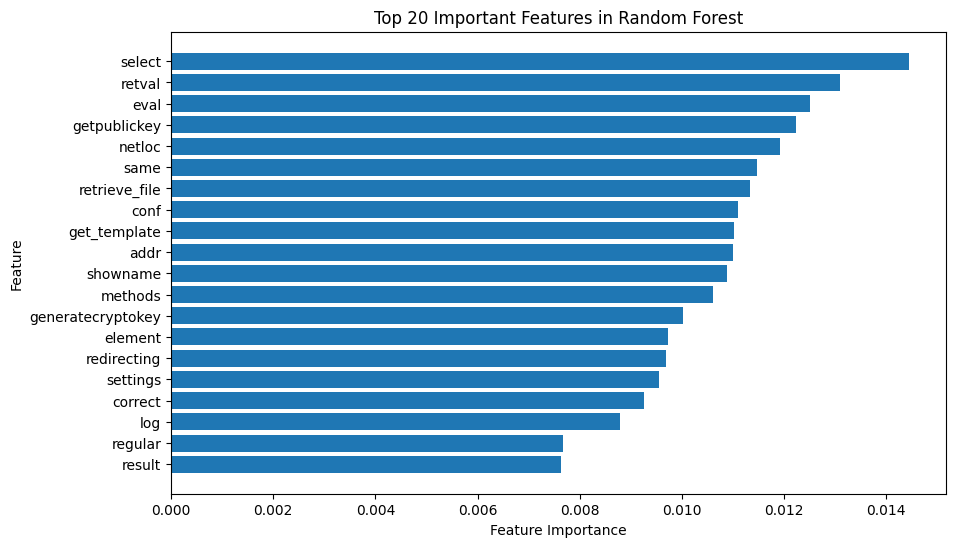

In [14]:
# Extracting feature importance from the best model
feature_importances = best_rf_clf.feature_importances_

# Get feature names from TfidfVectorizer
feature_names = vectorizer.get_feature_names_out()

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1][:20]  # Top 20 features
sorted_importances = feature_importances[sorted_idx]
sorted_feature_names = feature_names[sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names[::-1], sorted_importances[::-1])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 20 Important Features in Random Forest")
plt.show()

**Confusion Matrix**

In [15]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(best_rf_clf, X_test_vec, y_test, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

ValueError: X has 960 features, but RandomForestClassifier is expecting 768 features as input.

**Cross Validation Performance**

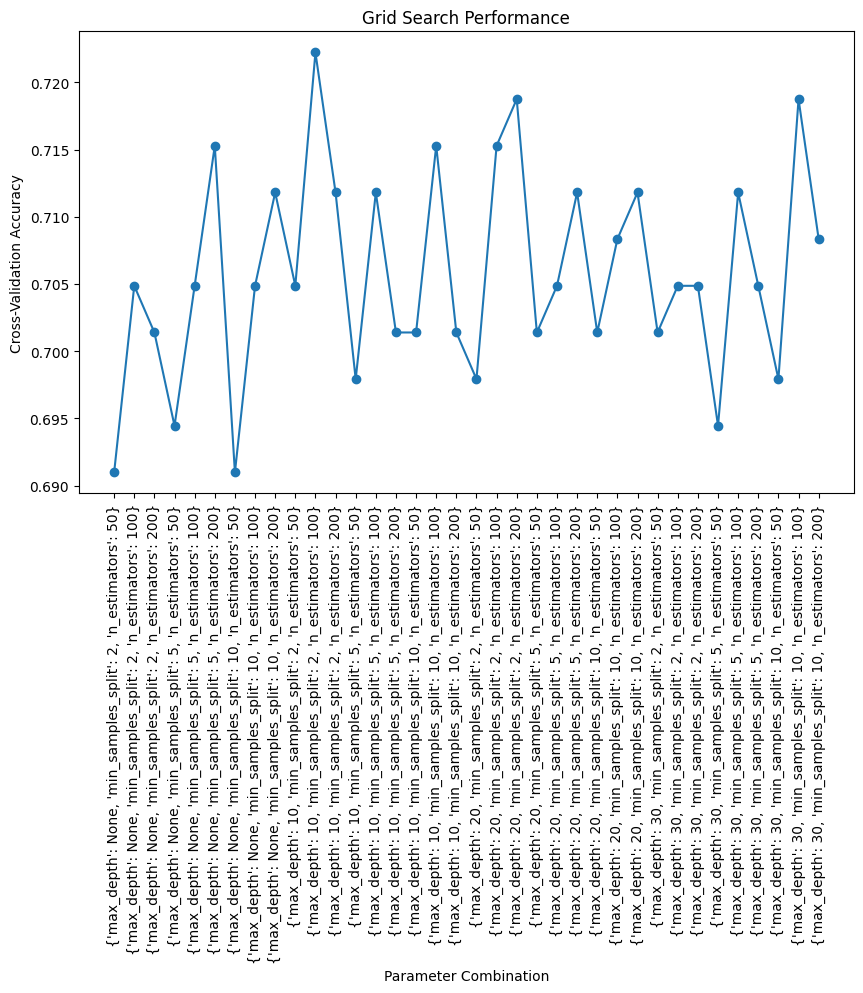

In [25]:
results = grid_search.cv_results_
scores = results['mean_test_score']
params = [str(x) for x in results['params']]

plt.figure(figsize=(10, 6))
plt.plot(params, scores, marker='o')
plt.xticks(rotation=90)
plt.xlabel("Parameter Combination")
plt.ylabel("Cross-Validation Accuracy")
plt.title("Grid Search Performance")
plt.show()

**ROC Curve**

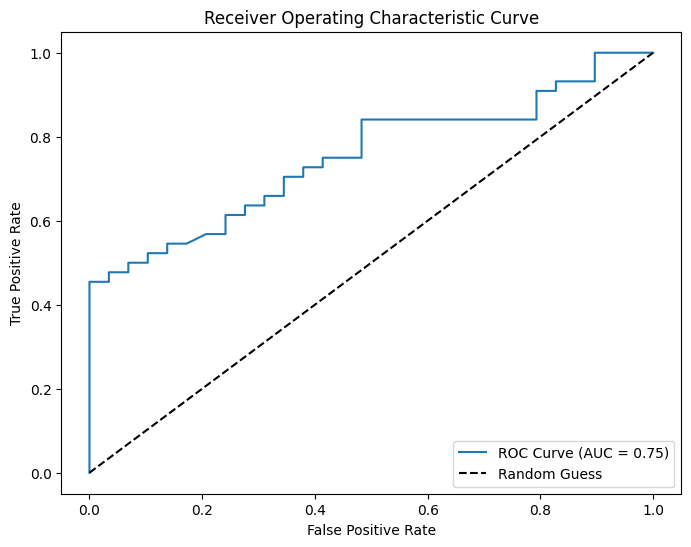

In [26]:
# Predict probabilities for the test set
y_prob = best_rf_clf.predict_proba(X_test_vec)[:, 1]  # Get probabilities for the positive class

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()